# Implementing a Neural Network
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it on the CIFAR-10 dataset.

In [1]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt

from net_utils.neural_net import TwoLayerNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
# This command in an IPython notebook enables the autoreload extension, which will automatically refresh imported modules when you modify their code files while the notebook is running. This saves you from having to constantly restart the kernel to see your code changes take effect.

%autoreload 2
# It sets the autoreload mode to 2, which enables automatic reloading of all imported modules (both top-level and nested)

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

We will use the class `TwoLayerNet` in the file `net_utils/neural_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [2]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `net_utils/neural_net.py` and look at the method `TwoLayerNet.loss`. This function takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [3]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.19783499 -0.45725921 -0.01091499]
 [-0.02199904 -2.57502858 -0.53320706]
 [ 0.13174073 -1.22436698  0.31713785]
 [ 0.07369857 -0.16689017 -0.67714531]
 [ 0.05227744 -0.10249148  0.00586793]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
6.682545707307306


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularization loss.

In [4]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
0.44751397304555596


# Backward pass
The gradient calculation has been implemented for you. This code will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`.

In [5]:
from net_utils.gradient_check import eval_numerical_gradient

# The difference between the numeric and analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

b2 max relative error: 1.000000e+00
W2 max relative error: 1.000000e+00
b1 max relative error: 1.000000e+00
W1 max relative error: 1.000000e+00


# Train the network
To train the network we will use stochastic gradient descent (SGD). Look at the function `TwoLayerNet.train` and fill in the missing sections to implement the training procedure. You will also have to implement `TwoLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.02.

Final training loss:  0.3097073516695319


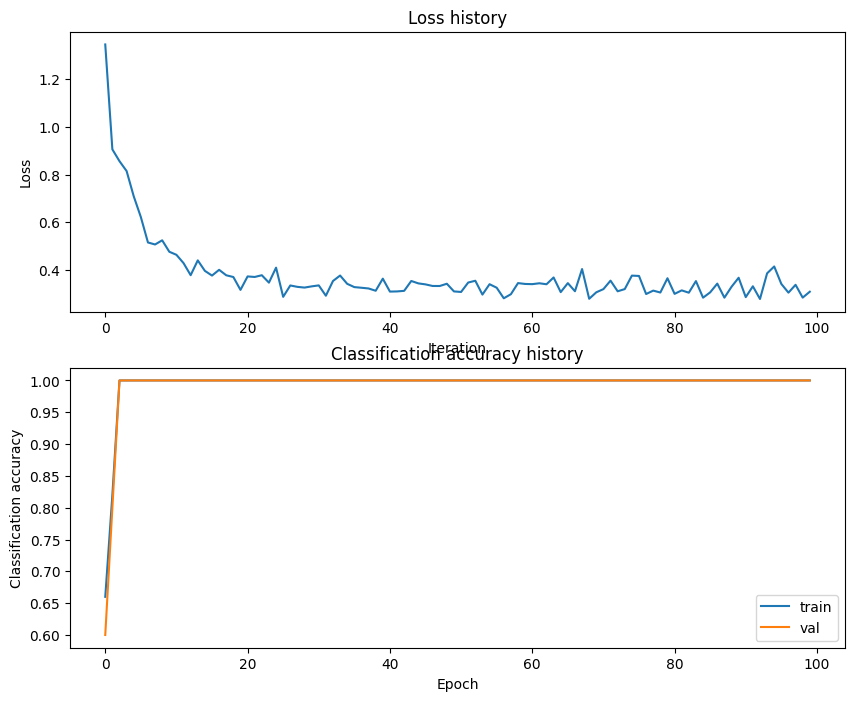

In [6]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

# Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up the CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [50]:
from net_utils.data_utils import load_CIFAR10
from sklearn.decomposition import PCA

def get_CIFAR10_data(num_training=49000, num_validation=1000, 
                  num_test=1000, num_components=300):
   """
   Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
   it for the two-layer neural net classifier.
   """
   # Load the raw CIFAR-10 data
   cifar10_dir = 'net_utils/datasets/cifar-10-batches-py'
   
   # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
   try:
      del X_train, y_train
      del X_test, y_test
      print('Clear previously loaded data.')
   except:
      pass

   X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
      
   # Subsample the data
   mask = list(range(num_training, num_training + num_validation))
   X_val = X_train[mask]
   y_val = y_train[mask]
   mask = list(range(num_training))
   X_train = X_train[mask]
   y_train = y_train[mask]
   mask = list(range(num_test))
   X_test = X_test[mask]
   y_test = y_test[mask]
   
   # Normalize the data: subtract the mean image
   mean_image = np.mean(X_train, axis=0)
   X_train -= mean_image
   X_val -= mean_image
   X_test -= mean_image

   # Reshape data to rows
   X_train = X_train.reshape(num_training, -1)
   X_val = X_val.reshape(num_validation, -1)
   X_test = X_test.reshape(num_test, -1)
   
   # Apply PCA
   pca = PCA(n_components=num_components)
   pca.fit(X_train)  # Fit PCA only on training data
   X_train_pca = pca.transform(X_train)
   X_val_pca = pca.transform(X_val)
   X_test_pca = pca.transform(X_test)
   print('Variance explained by %d components: %.4f' % (num_components, np.sum(pca.explained_variance_ratio_)))

   # Inverse PCA transformation to original dimensions
   X_train = pca.inverse_transform(X_train_pca).reshape(-1, 3072)
   X_val = pca.inverse_transform(X_val_pca).reshape(-1, 3072)
   X_test = pca.inverse_transform(X_test_pca).reshape(-1, 3072)
   print('Inverse PCA transformation to original dimensions done!')

   return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(num_components=500)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:01<00:00,  4.47it/s]


Variance explained by 500 components: 0.9833
Inverse PCA transformation to original dimensions done!
Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Train a network
To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [51]:
input_size = 32 * 32 * 3
hidden_size = 150
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes, dropout=0.5)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=5000, batch_size=200,
            learning_rate=3e-3, learning_rate_decay=0.8,
            reg=0.0, tqdm_verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [03:24<00:00, 24.49it/s]


Validation accuracy:  0.522


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

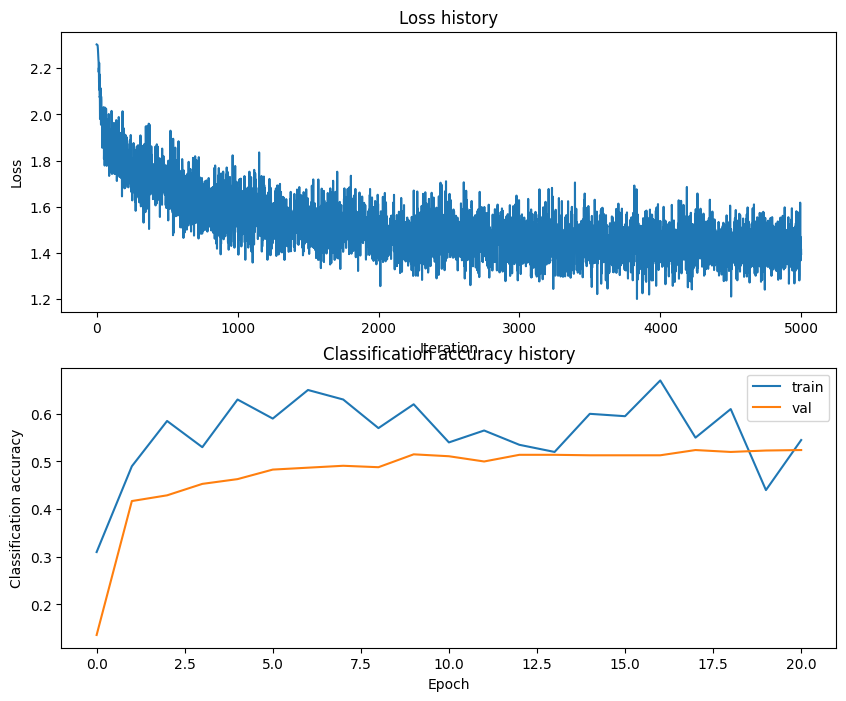

In [52]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

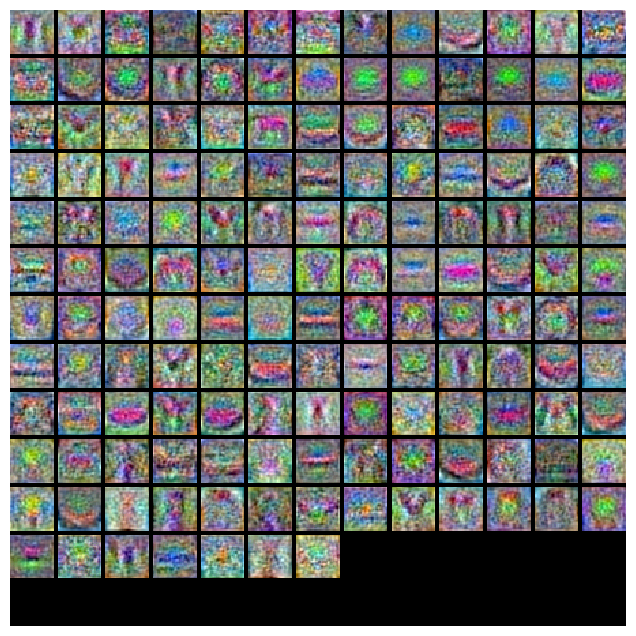

In [55]:
from net_utils.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

In [54]:
test_acc = (net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.525


# Tune the hyperparameters

**Obervation**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can (50% could serve as a reference), with a fully-connected Neural Network. Feel free to implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

**Explain your hyperparameter tuning process below.**

请解释你的超参数调整策略：

答：

In [302]:
#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
# *****START OF YOUR CODE*****

import json
import itertools
from tqdm import tqdm
from IPython.display import clear_output

best_net = None # Store the best model
best_config = None
best_val = -1
results = []

# Define hyperparameters
learning_rates = (3e-3, 1e-3, 1e-4)
hidden_sizes = (50, 75, 100)
iter_nums= (1000, 2000, 3000)
lr_decays = (0.5, 0.7, 0.8, 1.0)
regs = (0.003, 0.3, 30.0)

# Load existing results
try:
    with open('results.json', 'r') as f:
        results = json.load(f)
        existed_configs = {tuple(result.values())[:-1]: result for result in results}  # Create a dict of configurations
except FileNotFoundError:
    existed_configs = {}
    print("No existing results found")

# Load the best network and configuration
try:
    best_net = np.load('best_net.npy', allow_pickle=True).item()
    with open('best_config.json', 'r') as f:
        best_config = json.load(f)
        best_val = best_config['val_acc']
except FileNotFoundError:
    print("No best network found")

# Function to create a dictionary from configuration and accuracy
def config_to_json(config, acc):
    labels = ['iter_num', 'hidden_size', 'learning_rate', 'lr_decay', 'reg', 'val_acc'] # To modify
    return dict(zip(labels, list(config) + [acc]))

# Iterate over all combinations of hyperparameters
for config in tqdm(list(itertools.product(iter_nums, hidden_sizes, learning_rates, lr_decays, regs))):
    if config in existed_configs:
        tqdm.write(f"Config {config} already exists with accuracy {existed_configs[config]['val_acc']}")
        continue

    iter_n, hs, lr, lrd, reg = config
    net = TwoLayerNet(input_size, hs, num_classes)
    stats = net.train(X_train, y_train, X_val, y_val, num_iters=iter_n, batch_size=200, \
        learning_rate=lr, learning_rate_decay=lrd, reg=reg, tqdm_verbose=False)
    val_acc = (net.predict(X_val) == y_val).mean()

    # Update results
    new_result = config_to_json(config, val_acc)
    print(new_result)
    results.append(new_result)
    with open('results.json', 'w') as f:
        json.dump(results, f)
    if val_acc > best_val:
        best_val = val_acc
        best_net = net
        best_config = config_to_json(config, val_acc)
        np.save('best_net.npy', best_net, allow_pickle=True)
        with open('best_config.json', 'w') as f:
            json.dump(best_config, f)

# Save final results to JSON
with open('results.json', 'w') as f:
    json.dump(results, f)
clear_output()

print(f"Best validation accuracy achieved during cross-validation: {best_val:.4f}")

best_net = TwoLayerNet(input_size, best_config['hidden_size'], num_classes)
stats = best_net.train(X_train, y_train, X_val, y_val, num_iters=best_config['iter_num'], batch_size=200, \
    learning_rate=best_config['learning_rate'], learning_rate_decay=best_config['lr_decay'], \
    reg=best_config['reg'], tqdm_verbose=True)
val_acc = (best_net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)
# *****END OF YOUR CODE*****

  0%|          | 1/324 [00:17<1:34:44, 17.60s/it]

{'iter_num': 1000, 'hidden_size': 50, 'learning_rate': 0.003, 'lr_decay': 0.5, 'reg': 0.003, 'val_acc': 0.468}


  1%|          | 2/324 [00:34<1:31:34, 17.06s/it]

{'iter_num': 1000, 'hidden_size': 50, 'learning_rate': 0.003, 'lr_decay': 0.5, 'reg': 0.3, 'val_acc': 0.482}


  1%|          | 2/324 [00:44<1:58:36, 22.10s/it]


KeyboardInterrupt: 

In [ ]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

In [ ]:
# visualize the weights of the best network
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

In [ ]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)